In [1]:
!pip install roboflow
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 593.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.8/823.8 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)

In [38]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import zipfile
from roboflow import Roboflow
import torch
from torchvision import transforms
from PIL import Image, ImageDraw
import tensorboard
import torchvision

In [3]:
# mount data set into drive
# change the api key and project name before uploading to github

rf = Roboflow(api_key="IYwf0SjALphOAs60cx0U")
project = rf.workspace("myworkspace-zkmzj").project("license-plate-detector-no-brand")
version = project.version(1)
dataset = version.download("yolov8")



loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.63, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to License-Plate-Detector---no-brand-1 in yolov8:: 100%|██████████| 4248/4248 [00:08<00:00, 475.97it/s]


In [4]:
# # Define paths to your dataset folders
train_folder = "License-Plate-Detector---no-brand-1/train/"
test_folder = "License-Plate-Detector---no-brand-1/test/"
val_folder = "License-Plate-Detector---no-brand-1/valid/"

# # Get list of all image files in the images folder
train_image_files = sorted(os.listdir(os.path.join(train_folder, "images")))
train_annotation_files = sorted(os.listdir( os.path.join(train_folder, "labels"))) # format is each line has class, top left x, top left y, bot right x, bot right y

test_image_files = sorted(os.listdir(os.path.join(test_folder, "images")))
test_annotation_files = sorted(os.listdir( os.path.join(test_folder, "labels")))

val_image_files = sorted(os.listdir(os.path.join(val_folder, "images")))
val_annotation_files = sorted(os.listdir( os.path.join(val_folder, "labels")))



In [5]:
class_names = ['Car', 'Plate']
# colours = np.random.uniform(0,255, size=(len(class_names),3)).astype(int)
colours = [(139,47,247),(197,239,228)]

In [6]:
# converts yolo formatted bounding box to a cv2 possible bounding box
# yolo format is center of the rectangle or something stupid
def yolo2bbox(bboxes):
  xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
  xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
  return xmin, ymin, xmax, ymax #becomes the top left and bottom right corner

In [7]:
import matplotlib.pyplot as plt
import cv2
import random

def plot_box(image, bboxes, labels):
    for bbox, label in zip(bboxes, labels):
        x_c, y_c, w, h = bbox
        x1 = int((x_c - w / 2) * image.shape[1])
        y1 = int((y_c - h / 2) * image.shape[0])
        x2 = int((x_c + w / 2) * image.shape[1])
        y2 = int((y_c + h / 2) * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), colours[int(label)], 2)
        # cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return image
def plot_image(image_paths, label_paths, num_samples):
    num_images = len(image_paths)
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images - 1)
        image = cv2.imread(train_folder + "/images/" + image_paths[j])
        with open(train_folder + "/labels/" + label_paths[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for line in label_lines:
                label = line[0]
                bbox_string = line[2:].strip()  # strip to remove any extra spaces/newlines
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
            new_img = plot_box(image, bboxes, labels)
            plt.subplot(2, 2, i + 1)
            plt.imshow(new_img[:, :, ::-1])
            plt.axis('off')

    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/My Drive/MSc Project/Saved Models/yolov8n.pt'


Mounted at /content/gdrive


In [9]:
from ultralytics import YOLO

yolo_model = YOLO(drive_path)

In [10]:

def load_image(img_path):
    img = Image.open(img_path)
    img = transforms.ToTensor()(img).unsqueeze(0)
    return img

img_path = "/content/"+test_folder+"/images/"+test_image_files[0]
img = load_image(img_path)

# trained_model.eval()
with torch.no_grad():
  detection = yolo_model(img)
  # need to add /content/ to the front of the train and val paths in data.yml


0: 640x640 2 Cars, 1 Plate, 1027.1ms
Speed: 0.1ms preprocess, 1027.1ms inference, 59.9ms postprocess per image at shape (1, 3, 640, 640)


In [11]:
%cd /content/License-Plate-Detector---no-brand-1


/content/License-Plate-Detector---no-brand-1


In [12]:
%ls

data.yaml  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [14]:
metrics = yolo_model.val(data='data.yaml', split='test')  # evaluate model performance on the test set


Ultralytics YOLOv8.2.63 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)


100%|██████████| 755k/755k [00:00<00:00, 15.6MB/s]
val: Scanning /content/License-Plate-Detector---no-brand-1/test/labels... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00:00<00:00, 1809.45it/s]

val: New cache created: /content/License-Plate-Detector---no-brand-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.12s/it]


                   all         64        203      0.944       0.83       0.91      0.729
                   Car         61        125      0.904       0.83      0.898       0.75
                 Plate         64         78      0.985      0.829      0.923      0.708
Speed: 16.5ms preprocess, 402.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2


In [15]:
curves = metrics.curves_results

In [16]:
len(curves[0][0]),len(curves[0][1]),len(curves[0][2]),len(curves[0][3])

(1000, 2, 6, 9)

In [18]:
recall = curves[0][1][0]
# recall = recall[::-1]
precision = curves[0][1][1]
# precision = precision

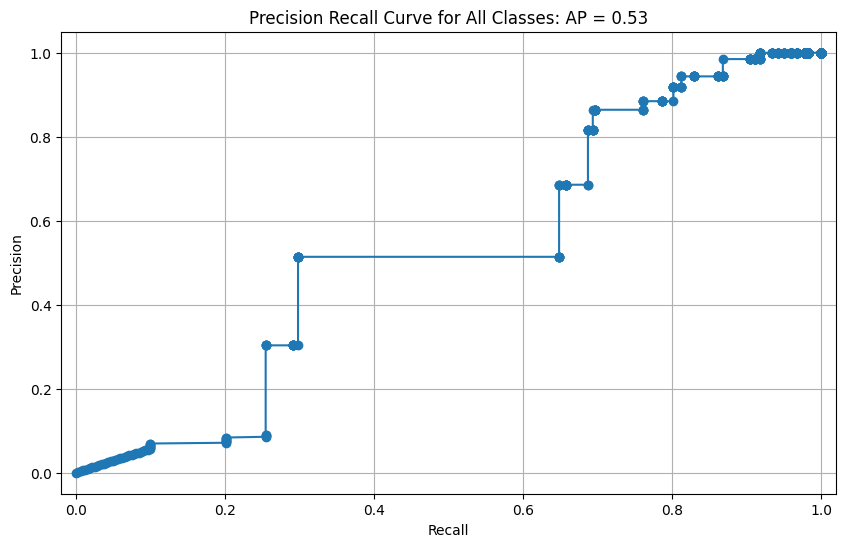

In [19]:
from sklearn.metrics import auc

auc_pr = auc(recall, precision)
plt.figure(figsize = (10,6))
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision Recall Curve for All Classes: AP = {auc_pr:.2f}')
plt.xlim(min(recall)-0.02,max(recall)+0.02)

plt.grid(True)
plt.show()

In [21]:
curves[3]

[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
           0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
           0.048048,    0.049049,     0.05005,    0.051051,    0.052052,    0.053053,    0.054054,    0.055055,    0.056056,    0.057057,    0.058058,    0.059059,     0.06006,    0.061061,    0.062062,    0.063063,    0.064064,    0.065065,    0.066066,    0.067067,    0.068068,    0.069069,     0.07007,    0.071071,
           0.072072,    0.073073,    0.0

In [22]:
len(recall), len(precision)

(1000, 1000)

#Detections vs True Labels

In [23]:
true_cars = 0
true_plates = 0
for file_path in test_annotation_files:
  with open('/content/'+test_folder + "labels/" + file_path, 'r') as f:
    labels = []
    label_lines = f.readlines()
    for line in label_lines:
      label = line[0]
      labels.append(label)


    true_cars += labels.count('0')
    true_plates += labels.count('1')

true_cars, true_plates

(125, 78)

In [24]:
def get_annotations(file_path):
  with open('/content/'+test_folder + "labels/" + file_path, 'r') as f:
    labels = []
    bboxes = []
    label_lines = f.readlines()
    for line in label_lines:
      label = line[0]
      labels.append(label)
      bbox_string = line[2:].strip()  # strip to remove any extra spaces/newlines
      x_c, y_c, w, h = bbox_string.split(' ')
      x_c = float(x_c)
      y_c = float(y_c)
      w = float(w)
      h = float(h)
      bboxes.append([x_c*640, y_c*640, w*640, h*640])
    print(labels)
    print(bboxes)


get_annotations(test_annotation_files[0])

['0', '0', '0', '1']
[[366.5, 226.0, 294.0, 173.5], [527.0, 193.5, 103.0, 96.0], [588.5, 168.5, 51.0, 90.5], [326.5, 256.0, 74.5, 18.0]]


In [25]:
def load_image(img_path):
    img = Image.open(img_path)
    img = transforms.ToTensor()(img).unsqueeze(0)
    return img

pred_cars = 0
pred_plates = 0
# Load image
for img_file, annot_file in zip(test_image_files, test_annotation_files):
  img_path = "/content/"+test_folder+"/images/"+img_file
  annot_path = "/content/"+test_folder+"/labels/"+annot_file
  img = load_image(img_path)


  with torch.no_grad():
    detections = yolo_model.predict(img)[0].boxes
    pred_cars += torch.sum(detections.cls == 0).item()
    pred_plates += torch.sum(detections.cls == 1).item()


0: 640x640 2 Cars, 1 Plate, 269.8ms
Speed: 0.0ms preprocess, 269.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 1 Plate, 234.8ms
Speed: 0.0ms preprocess, 234.8ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Cars, 1 Plate, 255.6ms
Speed: 0.0ms preprocess, 255.6ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Cars, 1 Plate, 225.8ms
Speed: 0.0ms preprocess, 225.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 1 Plate, 226.0ms
Speed: 0.2ms preprocess, 226.0ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 1 Plate, 216.0ms
Speed: 0.0ms preprocess, 216.0ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Cars, 1 Plate, 253.5ms
Speed: 0.0ms preprocess, 253.5ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 1 Plate, 232.3ms
Speed: 0.0ms preproc

In [26]:
detections.xywh, detections.conf

(tensor([[572.9352, 417.2318, 131.7592, 110.6801],
         [320.9511, 318.2924, 636.1134, 635.5645]]),
 tensor([0.8622, 0.8560]))

In [27]:
pred_cars,pred_plates

(132, 77)

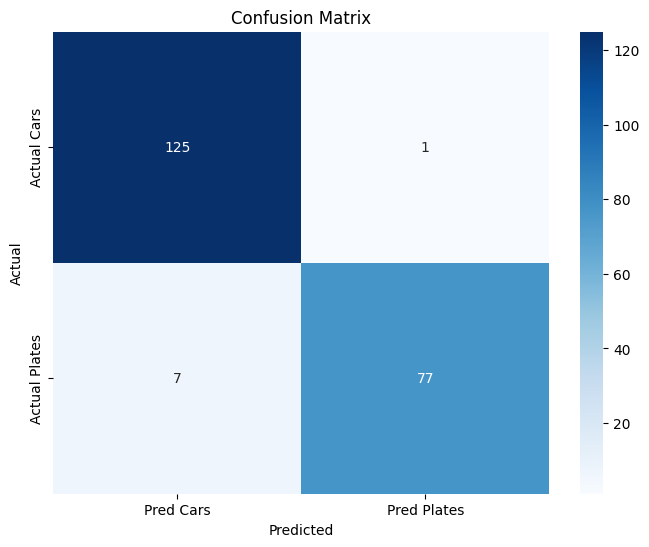

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix values
class1_actual = true_cars
class2_actual = true_plates
class1_predicted = pred_cars
class2_predicted = pred_plates

# Construct the confusion matrix
confusion_matrix = np.array([[class1_actual, class2_actual - class2_predicted],
                             [class1_predicted- class1_actual , class2_predicted]])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Cars', 'Pred Plates'], yticklabels=['Actual Cars', 'Actual Plates'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
import pandas as pd
data = {
    'Actual Cars': [true_cars],
    'Actual Plates': [true_plates],
    'Predicted Cars': [pred_cars],
    'Predicted Plates': [pred_plates]}
data_spread_df = pd.DataFrame(data)
data_spread_df.head()
data_spread_df.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Data_Spread.csv', index=False)

#Inferencing Times

In [30]:
import time
def load_image(img_path):
    img = Image.open(img_path)
    img = transforms.ToTensor()(img).unsqueeze(0)
    return img


# Load image
inferencing_times = []
imgs = []
for img_file in test_image_files:
  img_path = "/content/"+test_folder+"/images/"+img_file
  img = load_image(img_path)


  with torch.no_grad():
    speed = yolo_model.predict(img)[0].speed
    inferencing_times.append(sum(speed.values()))





0: 640x640 2 Cars, 1 Plate, 1368.5ms
Speed: 0.0ms preprocess, 1368.5ms inference, 41.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 1 Plate, 1069.9ms
Speed: 0.0ms preprocess, 1069.9ms inference, 14.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Cars, 1 Plate, 721.6ms
Speed: 0.0ms preprocess, 721.6ms inference, 19.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Cars, 1 Plate, 531.6ms
Speed: 0.0ms preprocess, 531.6ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 1 Plate, 423.9ms
Speed: 0.0ms preprocess, 423.9ms inference, 14.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 1 Plate, 443.8ms
Speed: 0.0ms preprocess, 443.8ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Cars, 1 Plate, 435.9ms
Speed: 0.0ms preprocess, 435.9ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 1 Plate, 437.4ms
Speed: 0.0ms

In [31]:
len(inferencing_times), max(inferencing_times), min(inferencing_times)

(64, 1410.1290702819824, 225.12221336364746)

In [32]:
import pandas as pd

inf_times = pd.DataFrame(inferencing_times, columns=['YOLO_Model'])
inf_times.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_inference_times.csv', index=False)

#Curves

In [67]:
# Load image
imgs = []
outputs = []
targets = []
idx = 0
for img_file, img_ann in zip(test_image_files, test_annotation_files):
  labels = []
  boxes = []

  img_path = "/content/"+test_folder+"/images/"+img_file
  img = load_image(img_path)
  ann_path = "/content/"+test_folder+"/labels/"+ img_ann
  with open(ann_path, 'r') as f:
    label_lines = f.readlines()
    for line in label_lines:
      labels.append(int(line[0]))
      bbox_string = line[2:].strip()  # strip to remove any extra spaces/newlines
      x_c, y_c, w, h = bbox_string.split(' ')
      x_c = float(x_c)
      y_c = float(y_c)
      w = float(w)
      h = float(h)
      x1 = int((x_c - w / 2) * img.shape[2])
      y1 = int((y_c - h / 2) * img.shape[3])
      x2 = int((x_c + w / 2) * img.shape[2])
      y2 = int((y_c + h / 2) * img.shape[3])
      boxes.append([x1,y1,x2,y2])
  targets.append({'labels':torch.tensor(labels), 'boxes':torch.tensor(boxes)})
  with torch.no_grad():
    detections = yolo_model.predict(img)
  outputs.append({'boxes':detections[0].boxes.xyxy,
                  'scores': detections[0].boxes.conf,
                  'labels': detections[0].boxes.cls})



0: 640x640 2 Cars, 1 Plate, 761.2ms
Speed: 0.1ms preprocess, 761.2ms inference, 21.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 1 Plate, 737.6ms
Speed: 0.0ms preprocess, 737.6ms inference, 22.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Cars, 1 Plate, 417.6ms
Speed: 0.0ms preprocess, 417.6ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Cars, 1 Plate, 247.2ms
Speed: 0.0ms preprocess, 247.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 1 Plate, 232.9ms
Speed: 0.0ms preprocess, 232.9ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 1 Plate, 240.9ms
Speed: 0.0ms preprocess, 240.9ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Cars, 1 Plate, 236.7ms
Speed: 0.0ms preprocess, 236.7ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 1 Plate, 228.0ms
Speed: 0.0ms prepr

In [46]:
outputs

[{'boxes': tensor([[222.1188, 141.9726, 513.6362, 314.1820],
          [290.5778, 246.4572, 364.7888, 264.8814],
          [478.1655, 146.9358, 572.9708, 236.8595]]),
  'scores': tensor([0.9095, 0.7373, 0.6089]),
  'labels': tensor([0., 1., 0.])},
 {'boxes': tensor([[206.3685, 204.0934, 565.2361, 322.2638],
          [222.6180, 274.7573, 268.9900, 287.9555]]),
  'scores': tensor([0.8152, 0.5828]),
  'labels': tensor([0., 1.])},
 {'boxes': tensor([[154.5713, 128.5859, 466.7474, 305.3885],
          [363.7407, 265.0582, 432.0760, 284.5400],
          [409.9896, 279.8790, 638.0524, 556.8322],
          [405.0616, 150.4746, 501.9008, 196.4951],
          [405.5504, 266.5609, 639.0166, 640.0000]]),
  'scores': tensor([0.9184, 0.7948, 0.7474, 0.7257, 0.6697]),
  'labels': tensor([0., 1., 0., 0., 0.])},
 {'boxes': tensor([[160.0032, 169.5678, 560.1147, 444.2335],
          [  1.2176, 138.2419, 244.3242, 341.5267],
          [220.7631, 345.7673, 364.8422, 388.1244],
          [616.1698, 194.81

In [68]:
targets

[{'labels': tensor([0, 0, 0, 1]),
  'boxes': tensor([[219, 139, 513, 312],
          [475, 145, 578, 241],
          [563, 123, 614, 213],
          [289, 247, 363, 265]])},
 {'labels': tensor([0, 1]),
  'boxes': tensor([[199, 205, 561, 322],
          [223, 275, 269, 288]])},
 {'labels': tensor([0, 0, 0, 1]),
  'boxes': tensor([[158, 129, 468, 301],
          [425, 281, 640, 639],
          [407, 146, 503, 202],
          [364, 266, 431, 285]])},
 {'labels': tensor([0, 0, 1]),
  'boxes': tensor([[161, 167, 574, 449],
          [  0, 130, 249, 339],
          [223, 348, 359, 387]])},
 {'labels': tensor([0, 0, 1]),
  'boxes': tensor([[135, 211, 457, 420],
          [324, 196, 640, 386],
          [287, 362, 390, 386]])},
 {'labels': tensor([0, 1]),
  'boxes': tensor([[ 51,  98, 534, 403],
          [353, 332, 471, 365]])},
 {'labels': tensor([0, 0, 0, 1]),
  'boxes': tensor([[373, 135, 497, 201],
          [ 88, 157, 471, 408],
          [291, 149, 339, 172],
          [268, 329, 381, 3

In [48]:
def reduce_prediction(boxes, scores,classes):
  conf_threshold = 0.5
  mask = scores >= conf_threshold
  boxes, scores, classes = boxes[mask], scores[mask], classes[mask]
  keeps = torchvision.ops.nms(boxes, scores, 0.5)

  # nms_boxes = nms(boxes, scores, 0.1) #returns a list of indexes of the good predictions
  return boxes[keeps].cpu(), scores[keeps].cpu(), classes[keeps].cpu()

In [75]:
def build_df(iou_threshold=0.5):
  total_cars= 0
  total_plates = 0
  col_names = ['Image', 'Confidence', 'TP', 'FP']
  car_df = pd.DataFrame(columns=col_names)
  plate_df = pd.DataFrame(columns=col_names)

  for i, pred in enumerate(outputs):
    boxes, scores, classes = reduce_prediction(pred['boxes'], pred['scores'], pred['labels'])
    true_boxes, true_classes = targets[i]['boxes'], targets[i]['labels']
    iou = torchvision.ops.box_iou(boxes, true_boxes)
    total_cars += torch.sum(true_classes == 0).item()
    total_plates += torch.sum(true_classes == 1).item()
    for box,score,cls in zip(boxes, scores, classes):
      iou = torchvision.ops.box_iou(box.reshape(1,4), true_boxes)
      matching_comp = torch.argmax(iou)
      if iou[0][matching_comp.item()].item() > iou_threshold:
        data_row = [f"Image {i}",score.item(), 1, 0]
      else:
        data_row = [f"Image {i}",score.item(), 0, 1]
      if true_classes[matching_comp.item()] == 0:
        car_df.loc[len(car_df.index)] = data_row
      elif true_classes[matching_comp.item()] == 1:
          plate_df.loc[len(plate_df.index)] = data_row
  return car_df, plate_df, total_cars, total_plates

In [51]:
def sort_df(df1, df2):
  df1 = df1.sort_values(by=['Confidence'], ascending=False)
  df1.reset_index(inplace=True, drop=True)
  # car_df.drop('index', axis=1)

  df2 = df2.sort_values(by=['Confidence'], ascending=False)
  df2.reset_index(inplace=True,drop=True)
  # df2 = df2.drop([0,1])
  # df2.reset_index(inplace=True, drop=True)

  return df1, df2

In [52]:
def PRCurve(df, total_detections):
  TP_acc = []
  FP_acc = []
  Precision = []
  Recall = []
  f1 = []
  for index, row in df.iterrows():
    if index == 0:
      if row['TP'] == 1:
        TP_acc.append(1)
        FP_acc.append(0)
      else:
        TP_acc.append(0)
        FP_acc.append(1)
      Precision.append(TP_acc[-1]/(TP_acc[-1]+FP_acc[-1]))
      Recall.append(TP_acc[-1]/total_detections)
      f1_score = 0 #2* (Precision[-1]*Recall[-1])/(Precision[-1]+Recall[-1])
      f1.append(f1_score)


    else:
      if row['TP'] == 1:
        TP_acc.append(TP_acc[index-1] + 1)
        FP_acc.append(FP_acc[-1])
      else:
        TP_acc.append(TP_acc[-1])
        FP_acc.append(FP_acc[index-1] + 1)
      Precision.append(TP_acc[-1]/(TP_acc[-1]+FP_acc[-1]))
      Recall.append(TP_acc[-1]/total_detections)
      f1_score = 2* (Precision[-1]*Recall[-1])/(Precision[-1]+Recall[-1])
      f1.append(f1_score)

  df['TP_acc'] = TP_acc
  df['FP_acc'] = FP_acc
  df['Precision'] = Precision
  df["Recall"] = Recall
  df['F1'] = f1
  return df


In [53]:
from sklearn.metrics import auc
def plot_PR_Curve(df, classStr):
  auc_pr = auc(df['Recall'], df['Precision'])
  plt.figure(figsize = (10,6))
  plt.plot(df['Recall'],df['Precision'], marker='o')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision Recall Curve for {classStr}: AP = {auc_pr:.2f}')
  plt.xlim(min(df['Recall'])-0.02,max(df['Recall'])+0.02)

  plt.grid(True)
  plt.show()

In [76]:
thresholds = [round(i/100, 2) for i in range(50, 100, 5)]

maps = []
# for i in range(len(thresholds)):
df1, df2, total_cars, total_plates = build_df(thresholds[0])
car_df, plate_df = sort_df(df1,df2)
carPR = PRCurve(car_df, total_cars)
platePR = PRCurve(plate_df, total_plates)
auc_car = auc(carPR['Recall'], carPR['Precision'])
auc_plate = auc(platePR['Recall'], platePR['Precision'])
maps.append(np.mean([auc_car, auc_plate]))

In [77]:
car_df

,Image,Confidence,TP,FP,TP_acc,FP_acc,Precision,Recall,F1
0,Image 20,0.955820,1,0,1,0,1.000000,0.008,0.000000
1,Image 14,0.952656,1,0,2,0,1.000000,0.016,0.031496
2,Image 11,0.950112,1,0,3,0,1.000000,0.024,0.046875
3,Image 22,0.949539,1,0,4,0,1.000000,0.032,0.062016
4,Image 23,0.945141,1,0,5,0,1.000000,0.040,0.076923
...,...,...,...,...,...,...,...,...,...
106,Image 40,0.585481,0,1,101,6,0.943925,0.808,0.870690
107,Image 30,0.548111,1,0,102,6,0.944444,0.816,0.875536
108,Image 6,0.537004,1,0,103,6,0.944954,0.824,0.880342
109,Image 11,0.519446,0,1,103,7,0.936364,0.824,0.876596


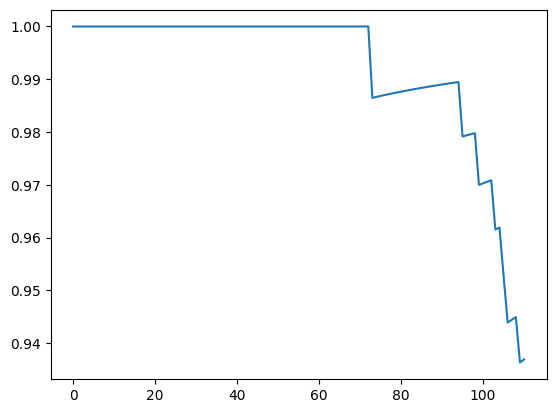

In [84]:
plt.plot(car_df['Precision'])

In [80]:
def plot_Curve(colx, coly, classStr,yLabel):
  # auc_pr = auc(df['Recall'], df['Precision'])
  plt.figure(figsize = (10,6))
  plt.plot(colx,coly, marker='o')
  plt.xlabel('Confidence')
  plt.ylabel(yLabel)
  plt.title(f'{yLabel} Curve for {classStr}')
  plt.xlim(min(colx)-0.02,max(colx)+0.02)

  # plt.xticks(rotation=45)
  plt.grid(True)
  plt.show()

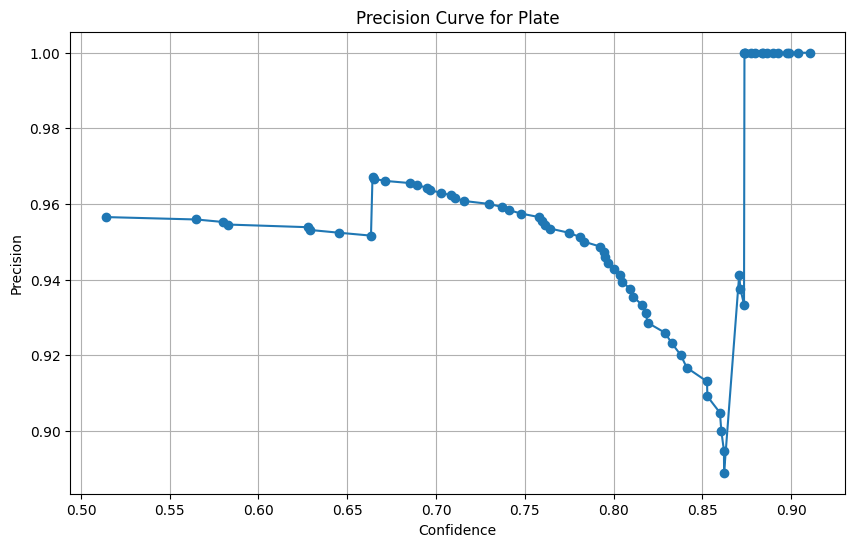

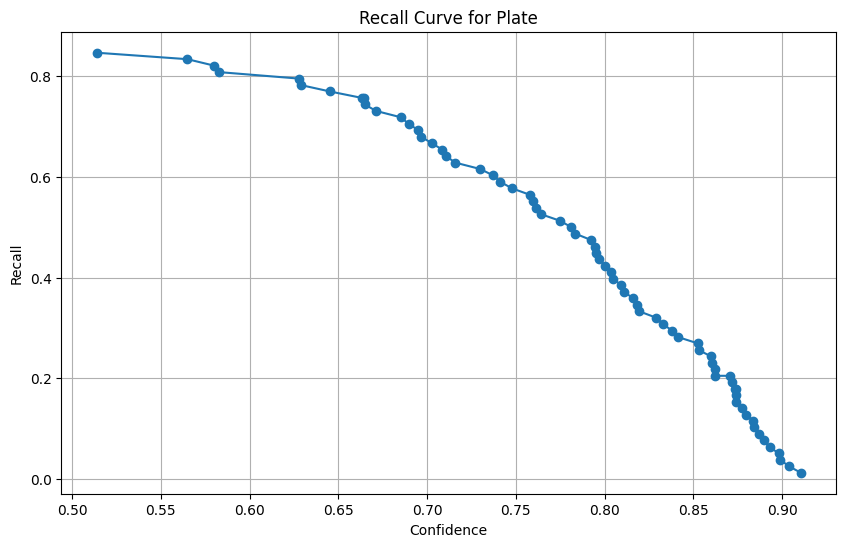

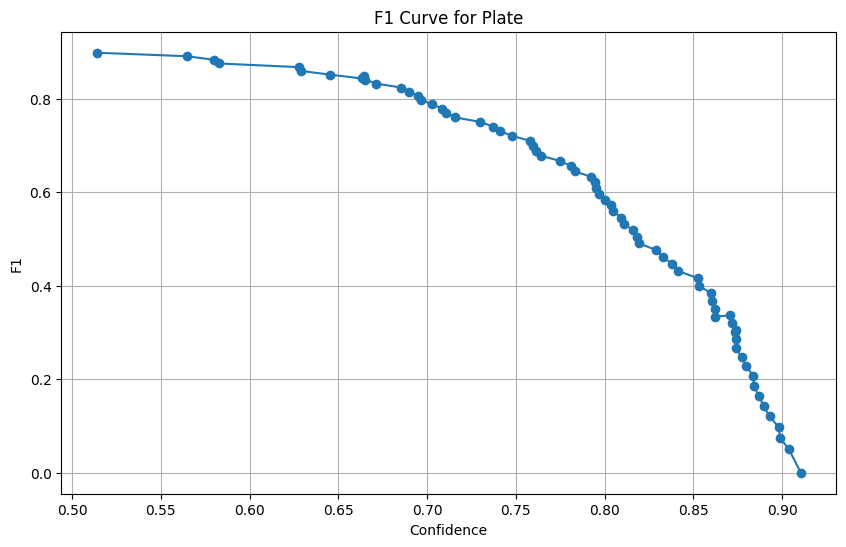

In [89]:
plot_Curve(platePR['Confidence'], platePR['Precision'], 'Plate', 'Precision')
plot_Curve(platePR['Confidence'], platePR['Recall'], 'Plate', 'Recall')
plot_Curve(platePR['Confidence'], platePR['F1'], 'Plate', 'F1')

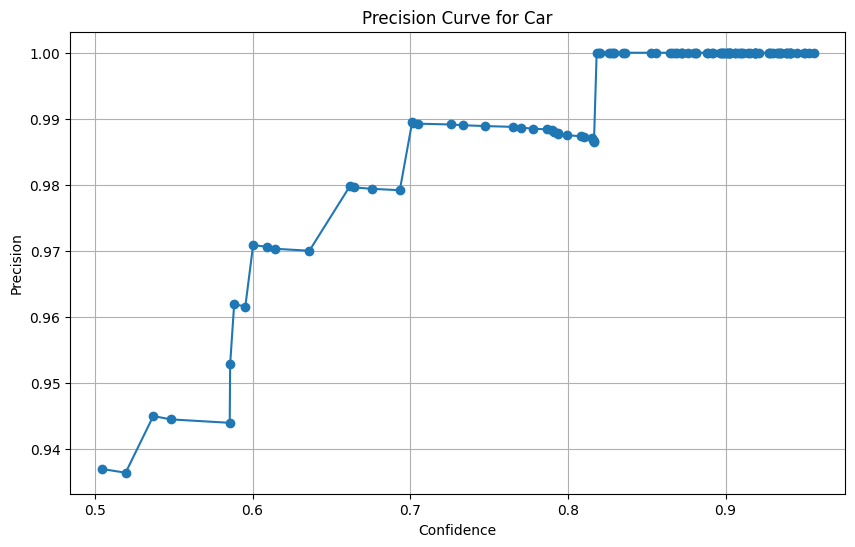

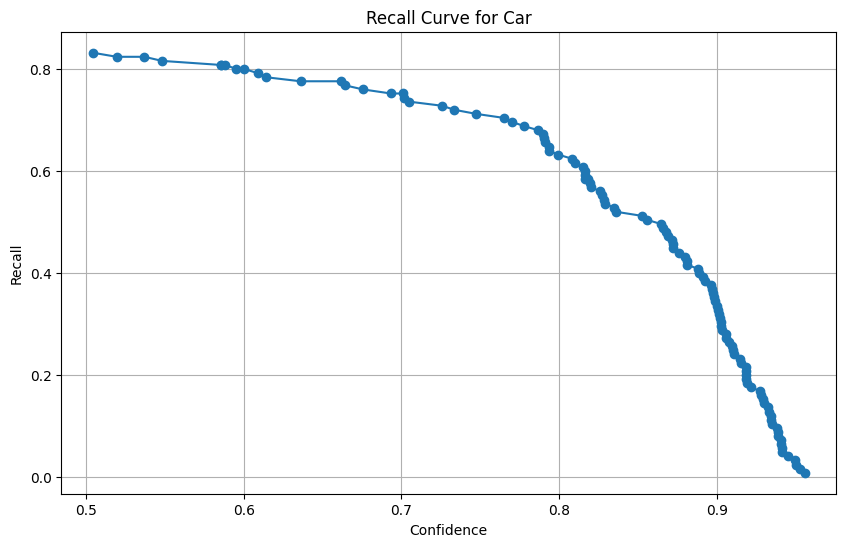

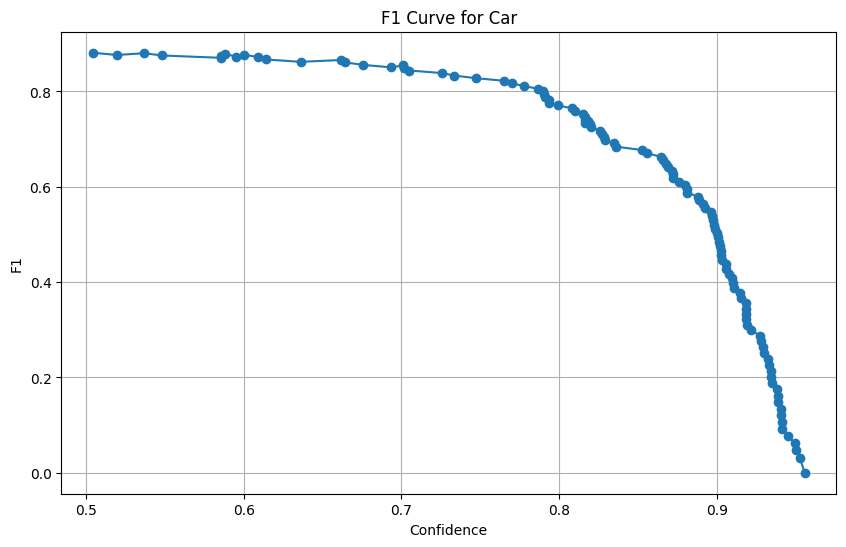

In [85]:
plot_Curve(carPR['Confidence'], carPR['Precision'], 'Car', 'Precision')
plot_Curve(carPR['Confidence'], carPR['Recall'], 'Car', 'Recall')
plot_Curve(carPR['Confidence'], carPR['F1'], 'Car', 'F1')

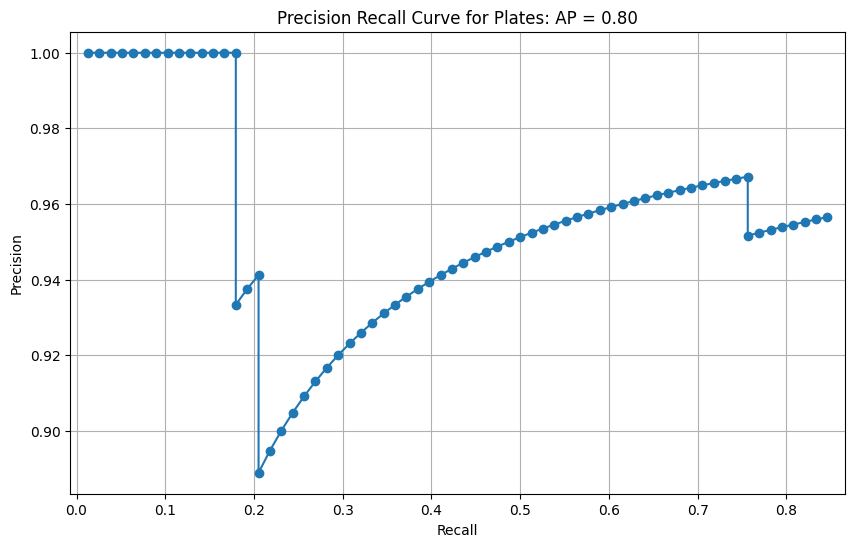

In [86]:
plot_PR_Curve(platePR, 'Plates')

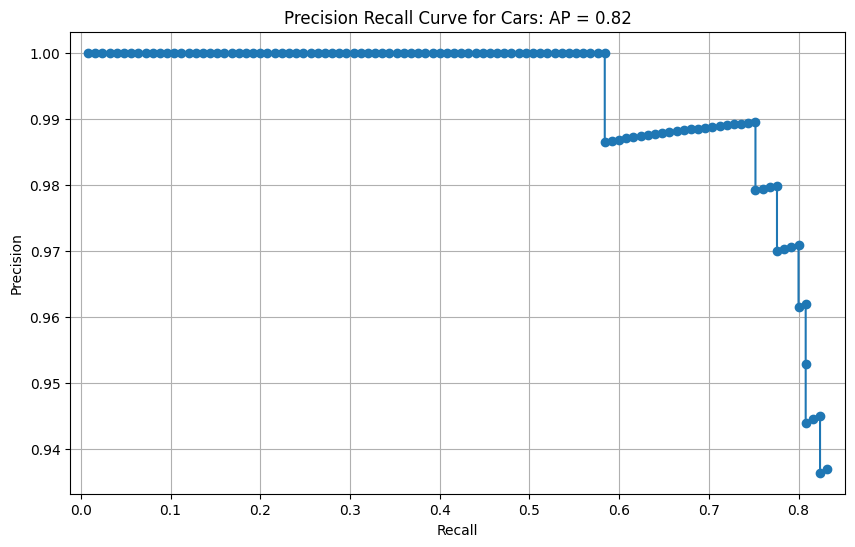

In [87]:
plot_PR_Curve(car_df, 'Cars')

In [88]:
carPR.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Car_Class_APRF.csv', index=False)
platePR.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Plate_Class_APRF.csv', index=False)